<a href="https://colab.research.google.com/github/UwailaEkhator/Accented-English-Speech-Recognition-and-Transcription/blob/main/Finetuning_Whisper_on_Phillipines_Accent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP PROJECT
- Sharadha
- Tapiwa
- Uwaila

## Finetuning Whisper using more Filipino accents
Currently, using Whisper, Filipino accents had a WER of about 0.5. We want to finetune Whisper using more data of people with Filipino accents to see if it improves Whispers performance and reduces the WER on Filipino accents

In [ ]:
#Prepare environment
#!pip install --upgrade pip
#!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio


In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
#Load dataset for finetuning
import pandas as pd
filipino_data = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/finetuning_train.csv')
filipino_data

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-001564.mp3,some storms are worth the wreckage,2,0,thirties,female,philippines,NaN
1,cv-valid-train/sample-001590.mp3,i'm just too miserable,1,0,twenties,female,philippines,NaN
2,cv-valid-train/sample-003933.mp3,love is the falcon's flight over your sands,1,0,twenties,male,philippines,NaN
3,cv-valid-train/sample-005077.mp3,continue in the direction of the pyramids said...,4,1,thirties,female,philippines,NaN
4,cv-valid-train/sample-005514.mp3,the land was ruined and i had to find some oth...,2,1,twenties,female,philippines,NaN
...,...,...,...,...,...,...,...,...
320,cv-valid-train/sample-194787.mp3,he had already seen many people come and go an...,1,0,fourties,male,philippines,NaN
321,cv-valid-train/sample-194976.mp3,if we serve tea in crystal the shop is going t...,1,0,twenties,male,philippines,NaN
322,cv-valid-train/sample-195045.mp3,you're in luck you two the fat arab said,6,0,thirties,male,philippines,NaN
323,cv-valid-train/sample-195239.mp3,i found these one day in the fields,3,0,thirties,male,philippines,NaN


In [ ]:
#drop unneccessary columns
filipino_data.drop(columns = ['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'], inplace=True)

In [ ]:
#removing cv-valid-train/ from 'filipino_data' dataframe
filipino_data['filename']=filipino_data['filename'].str.replace('cv-valid-train/', '')

In [ ]:
filipino_data

,filename,text
0,sample-001564.mp3,some storms are worth the wreckage
1,sample-001590.mp3,i'm just too miserable
2,sample-003933.mp3,love is the falcon's flight over your sands
3,sample-005077.mp3,continue in the direction of the pyramids said...
4,sample-005514.mp3,the land was ruined and i had to find some oth...
...,...,...
320,sample-194787.mp3,he had already seen many people come and go an...
321,sample-194976.mp3,if we serve tea in crystal the shop is going t...
322,sample-195045.mp3,you're in luck you two the fat arab said
323,sample-195239.mp3,i found these one day in the fields


In [ ]:
train_filipino = filipino_data

In [ ]:
#Prepare Feature Extractor, Tokenizer and Data

#Load WhisperFeatureExtractor
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny.en")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Load WhisperTokenizer
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")

In [ ]:
#Testing the tokenizer
input_str = train_filipino["text"][0]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")


Input:                 some storms are worth the wreckage
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>some storms are worth the wreckage<|endoftext|>
Decoded w/out special: some storms are worth the wreckage
Are equal:             True


In [ ]:
#combining the feature extractor and tokenizer to create a WhisperProcessor
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")


In [ ]:
#!pip install datasets
from datasets import Dataset, Audio, load_dataset

In [ ]:
#Prepare training data

#audio files directory
audio_directory = '/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/finetuning_train_audio'

#add path to audio files
train_filipino['audio'] = train_filipino['filename'].apply(lambda x: f"{audio_directory}/{x}")

#convert dataframe to datasets dataset
train_fili_dataset1 = Dataset.from_pandas(train_filipino)

In [ ]:
train_filipino

,filename,text,audio
0,sample-001564.mp3,some storms are worth the wreckage,/content/drive/Shareddrives/NLP Shared/NLP Pro...
1,sample-001590.mp3,i'm just too miserable,/content/drive/Shareddrives/NLP Shared/NLP Pro...
2,sample-003933.mp3,love is the falcon's flight over your sands,/content/drive/Shareddrives/NLP Shared/NLP Pro...
3,sample-005077.mp3,continue in the direction of the pyramids said...,/content/drive/Shareddrives/NLP Shared/NLP Pro...
4,sample-005514.mp3,the land was ruined and i had to find some oth...,/content/drive/Shareddrives/NLP Shared/NLP Pro...
...,...,...,...
320,sample-194787.mp3,he had already seen many people come and go an...,/content/drive/Shareddrives/NLP Shared/NLP Pro...
321,sample-194976.mp3,if we serve tea in crystal the shop is going t...,/content/drive/Shareddrives/NLP Shared/NLP Pro...
322,sample-195045.mp3,you're in luck you two the fat arab said,/content/drive/Shareddrives/NLP Shared/NLP Pro...
323,sample-195239.mp3,i found these one day in the fields,/content/drive/Shareddrives/NLP Shared/NLP Pro...


In [ ]:
# Get the audio column value of the first row
audio_first_row = train_filipino.loc[323, 'audio']

# Print the audio column value of the first row
audio_first_row

'/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/finetuning_train_audio/sample-195239.mp3'

In [ ]:
train_fili_dataset1

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 325
})

In [ ]:
# Cast the audio column to Audio feature with a sampling rate of 16,000 Hz
train_fili_dataset = train_fili_dataset1.cast_column("audio", Audio(sampling_rate=16000))
train_fili_dataset


Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 325
})

In [ ]:
#train_fili_dataset['audio'][0]

In [ ]:

def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text"]).input_ids
    return batch

train_fili_dataset = train_fili_dataset.map(prepare_dataset, remove_columns=train_fili_dataset.column_names, num_proc=4)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/325 [00:00<?, ? examples/s]

In [ ]:
#preparing test data
test_filipino = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/finetunining_test+dev.csv')

#audio files directory
audio_directory2 = '/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/finetunining_test+dev_audio'

#add path to audio files
test_filipino['audio'] = test_filipino['filename'].apply(lambda x: f"{audio_directory2}/{x}")

#convert dataframe to datasets dataset
test_fili_dataset1 = Dataset.from_pandas(test_filipino)

# Cast the audio column to Audio feature with a sampling rate of 16,000 Hz
test_fili_dataset = test_fili_dataset1.cast_column("audio", Audio(sampling_rate=16000))


test_fili_dataset = test_fili_dataset.map(prepare_dataset, remove_columns=test_fili_dataset.column_names, num_proc=4)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/14 [00:00<?, ? examples/s]

In [ ]:
test_fili_dataset

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 14
})

In [ ]:
#Training and Evaluation

#Define a Data Collator
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
#initializing the data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


In [ ]:
#!pip install evaluate
#!pip install jiwer

In [ ]:
#Evaluation metrics
#!pip install evaluate jiwer
import evaluate

metric = evaluate.load("wer")

#a function that takes our models predictions and returns the WER
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}



In [ ]:
#Loading the pretrained whisper tiny that we used earlier
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

In [ ]:
#print(model.config)


In [ ]:
#setting the language and task argument
#model.generation_config.language = "english"
#model.generation_config.task = "transcribe"

#model.generation_config.forced_decoder_ids = None


In [ ]:
#!pip uninstall accelerate transformers

In [ ]:
#!pip install accelerate>=0.20.3 transformers

In [ ]:
#Define training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/new2",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=2e-5,
    warmup_steps=50,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=6,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)


In [ ]:
#forwarding the training arguments, dataset, data collator and compute_metrics to our Trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_fili_dataset,
    eval_dataset=test_fili_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    #feature_extractor=processor.feature_extractor
)



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
#Training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
10,4.513900,4.133435,36.774194
20,3.773800,3.003018,30.322581
30,2.598300,2.066342,21.935484
40,1.964900,1.674097,12.903226
50,1.504500,1.426000,14.838710
60,1.217000,1.246091,24.516129
70,0.978200,1.050005,32.258065
80,0.732000,0.854693,12.258065
90,0.534600,0.684138,9.677419
100,0.353200,0.538925,9.677419


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarnin

TrainOutput(global_step=500, training_loss=0.3731366324527189, metrics={'train_runtime': 1581.0007, 'train_samples_per_second': 5.06, 'train_steps_per_second': 0.316, 'total_flos': 1.9072250302464e+17, 'train_loss': 0.3731366324527189, 'epoch': 23.81})

In [ ]:
#import transformers

In [ ]:
#!pip install sentence-transformers==2.3.1
#!pip install transformers==4.37.2

In [ ]:
from transformers import pipeline

# Define the path to the trained model directory
model_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/new2/checkpoint-110"

# Load the tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")


whisper_pipe = pipeline("automatic-speech-recognition",
    model=model_path,
    tokenizer=tokenizer)

# Perform inference using the pipeline
audio_file_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/new_recordings/filipino2.mp3"  # Specify the path to the audio file you want to transcribe
transcription_ft = whisper_pipe(audio_file_path)

# Print the transcription


In [ ]:
transcription_ft['text']

'please call Stella ask her to bring these things with her through the store six balloons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob we also need a small plastic snake and a big toy front for the kids she can scoop these things into three red bags and we will go meet her Wednesday at the train station'

In [ ]:
filename = '/content/drive/Shareddrives/NLP Shared/NLP Project/new_recordings/filipino2.mp3'
audio, sr = librosa.load(filename, sr=16000)

waveform = audio
sampling_rate = sr

# Load the Whisper model in Hugging Face format:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

# Use the model and processor to transcribe the audio:
input_features = processor(
    waveform, sampling_rate=sampling_rate, return_tensors="pt"
).input_features

# Generate token ids
predicted_ids = model.generate(input_features)

# Decode token ids to text
transcription_og = processor.batch_decode(predicted_ids, skip_special_tokens=True)

transcription_og[0]

" Please call Stella, ask her to bring these things with her food store. 6'2 fresh no peas, 5'5'5'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'2'"

In [ ]:
reference_text = 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'

In [ ]:
from evaluate import load
wer = load("wer")
wer_score = wer.compute(predictions=[transcription_ft['text']], references=[reference_text])

In [ ]:
wer_score

0.2318840579710145

In [ ]:
wer_score = wer.compute(predictions=[transcription_og[0]], references=[reference_text])
wer_score

0.8405797101449275

## Applying original whisper to the phlippines country accents from initial kaggle dataset and measuring WER

In [ ]:
import os
import librosa

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

In [ ]:
# Load the Whisper model in Hugging Face format:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

In [ ]:
# Path to the directory containing audio files
input_folder = '/content/drive/Shareddrives/NLP Shared/NLP Project/phil_rec'

# Check if the directory exists
if not os.path.isdir(input_folder):
    print(f"The directory '{input_folder}' does not exist.")
    exit()

# List all audio files in the directory
audio_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.mp3')])

# Check if any audio files are found
if not audio_files:
    print(f"No audio files found in '{input_folder}'.")
    exit()

# Load the Whisper model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

# List to store transcriptions
transcriptions = {}

# Process each audio file in the list
for audio_file in audio_files:
    audio_path = os.path.join(input_folder, audio_file)

    # Load the audio file and resample to 16000 Hz
    audio, sr = librosa.load(audio_path, sr=16000)

    # Use the model and processor to transcribe the audio
    input_features = processor(audio, sampling_rate=sr, return_tensors="pt").input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Append transcription to the list
    transcriptions[audio_file] = transcription


In [ ]:
import csv

In [ ]:
# Path to the output CSV file
output_csv = 'original_whisper_fili.csv'

# Write transcriptions to CSV
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Transcription'])

    for key, value in transcriptions.items():
        writer.writerow([key, value])

## Applying Finetuned whisper to the phlippines country accents from initial kaggle dataset and measuring WER

In [ ]:
from transformers import pipeline
import os
import librosa

# Path to the trained model directory
model_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/new2/checkpoint-110"

# Load the tokenizer and model using the pipeline
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")
whisper_pipe = pipeline("automatic-speech-recognition",
    model=model_path,
    tokenizer=tokenizer)

# Path to the directory containing audio files
input_folder = '/content/drive/Shareddrives/NLP Shared/NLP Project/phil_rec'

# Check if the directory exists
if not os.path.isdir(input_folder):
    print(f"The directory '{input_folder}' does not exist.")
    exit()

# List all audio files in the directory
audio_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.mp3')])

# Check if any audio files are found
if not audio_files:
    print(f"No audio files found in '{input_folder}'.")
    exit()

# Dictionary to store transcriptions
transcriptions = {}

# Process each audio file in the list
for audio_file in audio_files:
    audio_path = os.path.join(input_folder, audio_file)

    # Perform inference using the pipeline
    transcription = whisper_pipe(audio_path)

    # Store the transcription
    transcriptions[audio_file] = transcription['text']



In [ ]:
# Path to the output CSV file
output_csv = 'finetuned_whisper_fili.csv'

# Write transcriptions to CSV
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Transcription'])

    for key, value in transcriptions.items():
        writer.writerow([key, value])

We extracted both csv file and merged with the initial csv file that has more columns. see below the new dataframe:

In [ ]:
import pandas as pd

In [ ]:
new_filipino_df = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/filipino_finetuning/custom_phil_data_after_applyingWP.csv')
new_filipino_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,original_whisper_transcriptions,finetuned_whisper_transcriptions
0,21,1.0,"cebu, philippines",cebuano1,cebuano,female,565,philippines,"Please call Stella, ask her to bring these th...",please call Stella ask her to bring these thin...
1,43,0.0,"quezon city, philippines",english140,english,male,515,philippines,"Please call Stella, ask her to bring these th...",please call Stella ask her to bring these thin...
2,20,0.0,"las pinas, philippines",english348,english,female,1237,philippines,Please call Stella. Ask her to bring these th...,please call Stella ask her to bring these thin...
3,23,4.0,"quezon city, philippines",filipino1,filipino,male,1068,philippines,"Please call Stella, ask her to bring these th...",please call Stella ask her to bring these thin...
4,21,3.0,"pasay, philippines",filipino2,filipino,female,1500,philippines,"Please call Stella, ask her to bring these th...",please call Stella ask her to bring these thin...


In [ ]:
#storing the reference text
reference_text = 'please call stella ask her to bring these things with her from the store six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother bob we also need a small plastic snake and a big toy frog for the kids she can scoop these things into three red bags and we will go meet her wednesday at the train station'

In [ ]:
import pandas as pd
import string

# Assuming your dataframe is already loaded and named new_indian_df
# Assuming the column name is 'Original_Whisper'

# Define a function to remove punctuation and convert to lowercase
def normalize_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the function to the column
new_filipino_df['original_whisper_transcriptions'] = new_filipino_df['original_whisper_transcriptions'].apply(normalize_text)
new_filipino_df['finetuned_whisper_transcriptions'] = new_filipino_df['finetuned_whisper_transcriptions'].apply(normalize_text)
new_filipino_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,original_whisper_transcriptions,finetuned_whisper_transcriptions
0,21,1.0,"cebu, philippines",cebuano1,cebuano,female,565,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
1,43,0.0,"quezon city, philippines",english140,english,male,515,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
2,20,0.0,"las pinas, philippines",english348,english,female,1237,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
3,23,4.0,"quezon city, philippines",filipino1,filipino,male,1068,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
4,21,3.0,"pasay, philippines",filipino2,filipino,female,1500,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
5,53,7.0,"bago city, philippines",ilonggo1,ilonggo,female,1902,philippines,please call stella ask her to bring these thi...,please call stila asked her to bring these th...
6,25,3.0,"clark field, philippines",japanese16,japanese,female,1537,philippines,please call stella as carter brings these thi...,please call stella as kurtabring these things ...
7,18,10.0,"manila, philippines",tagalog1,tagalog,male,359,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
8,39,6.0,"manila, philippines",tagalog10,tagalog,female,1812,philippines,please call stella ask her to bring things wi...,please call stella asked her to bring things w...
9,59,11.0,"manila, philippines",tagalog11,tagalog,female,1837,philippines,please call estella ask her to bring these th...,please call estella asked her to bring these t...


Applying WER:

In [ ]:
!pip install evaluate
from evaluate import load
!pip install jiwer
wer = load("wer")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.0 MB/s eta 0:00:00


In [ ]:
# Create an empty list to store the WER scores
wer_scores_or = []

# Iterate over each item in the 'original_whisper_transcriptions' column
for transcription in new_filipino_df['original_whisper_transcriptions']:
    # Compute the WER score
    wer_score = wer.compute(predictions=[transcription], references=[reference_text])
    # Append the WER score to the list
    wer_scores_or.append(wer_score)

# Add the list of WER scores as a new column to the dataframe
new_filipino_df['WER_Original'] = wer_scores_or

In [ ]:
# Create an empty list to store the WER scores
wer_scores_ft = []

# Iterate over each item in the 'finetuned_whisper_transcriptions' column
for transcription in new_filipino_df['finetuned_whisper_transcriptions']:
    # Compute the WER score
    wer_score = wer.compute(predictions=[transcription], references=[reference_text])
    # Append the WER score to the list
    wer_scores_ft.append(wer_score)

# Add the list of WER scores as a new column to the dataframe
new_filipino_df['WER_Finetuned'] = wer_scores_ft

In [ ]:
new_filipino_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,original_whisper_transcriptions,finetuned_whisper_transcriptions,WER_Original,WER_Finetuned
0,21,1.0,"cebu, philippines",cebuano1,cebuano,female,565,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.057971,0.130435
1,43,0.0,"quezon city, philippines",english140,english,male,515,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.000000,0.000000
2,20,0.0,"las pinas, philippines",english348,english,female,1237,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.043478,0.014493
3,23,4.0,"quezon city, philippines",filipino1,filipino,male,1068,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.072464,0.043478
4,21,3.0,"pasay, philippines",filipino2,filipino,female,1500,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.797101,0.043478
5,53,7.0,"bago city, philippines",ilonggo1,ilonggo,female,1902,philippines,please call stella ask her to bring these thi...,please call stila asked her to bring these th...,0.130435,0.115942
6,25,3.0,"clark field, philippines",japanese16,japanese,female,1537,philippines,please call stella as carter brings these thi...,please call stella as kurtabring these things ...,0.086957,0.086957
7,18,10.0,"manila, philippines",tagalog1,tagalog,male,359,philippines,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.043478,0.144928
8,39,6.0,"manila, philippines",tagalog10,tagalog,female,1812,philippines,please call stella ask her to bring things wi...,please call stella asked her to bring things w...,0.072464,0.130435
9,59,11.0,"manila, philippines",tagalog11,tagalog,female,1837,philippines,please call estella ask her to bring these th...,please call estella asked her to bring these t...,0.130435,0.246377


In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

<ipython-input-13-8258ae31a6d5>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=new_filipino_df, x="country", y="WER_Original", hue="sex", ax=ax,


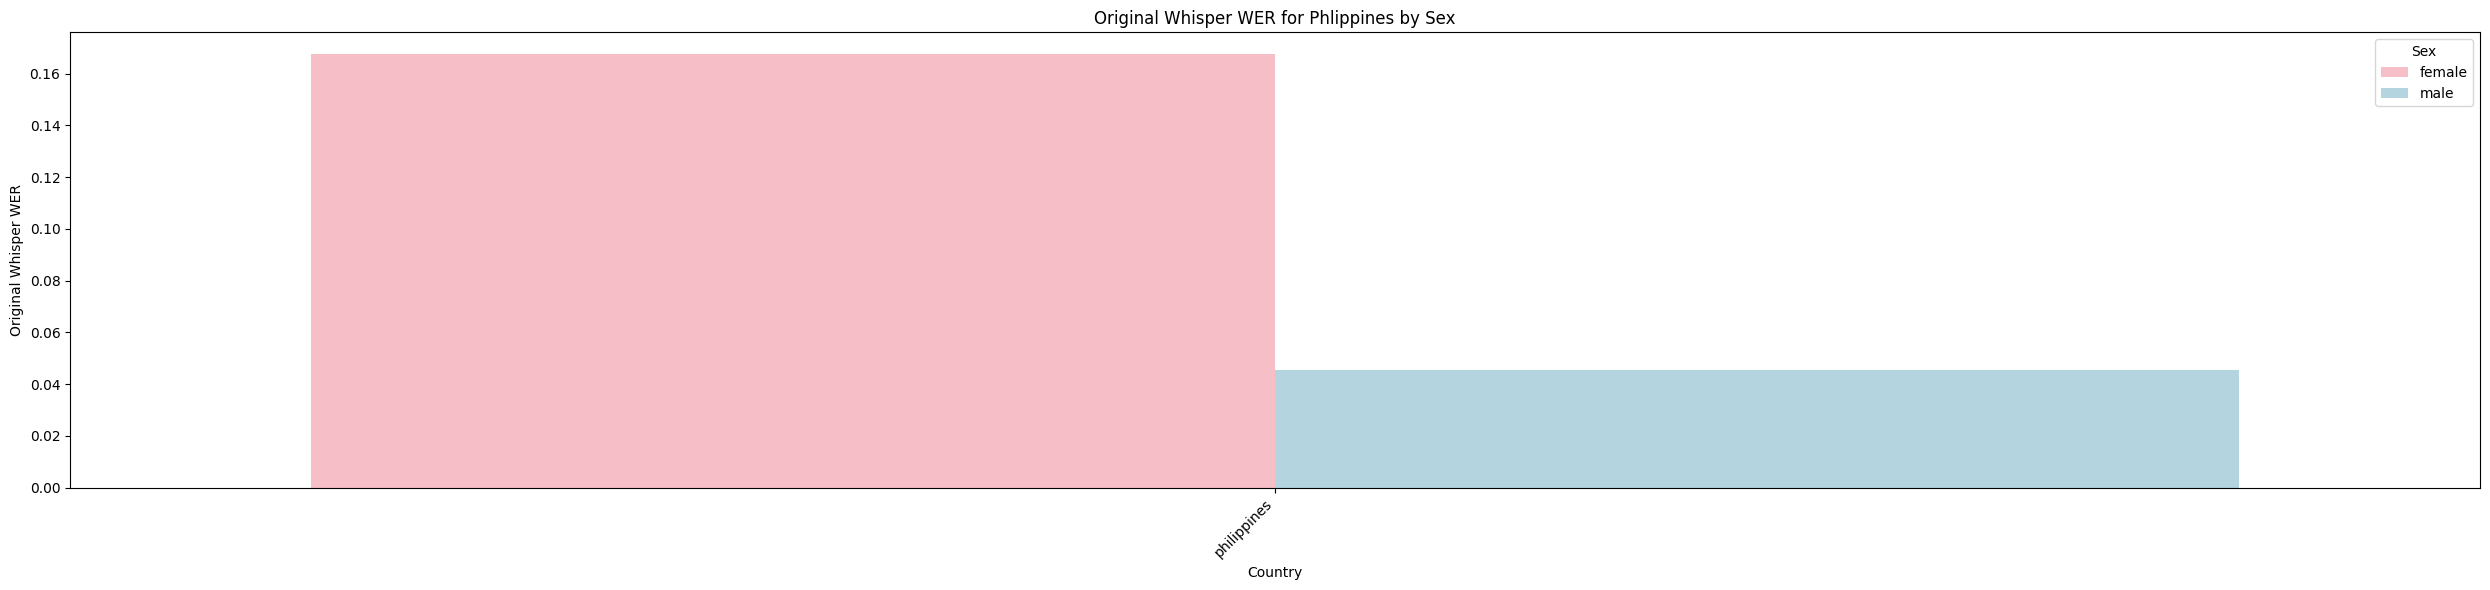

In [ ]:
#Plotting by sex

# Grouped bar plot
f = plt.figure(figsize=(25, 6))
ax = f.add_subplot(1, 1, 1)
color_palette = {"male": "lightblue", "female": "lightpink"}

# Plot
sns.barplot(data=new_filipino_df, x="country", y="WER_Original", hue="sex", ax=ax,
            palette=color_palette, ci=None)

# Customizing the plot
ax.set_title("Original Whisper WER for Phlippines by Sex")
ax.set_xlabel("Country")
ax.set_ylabel("Original Whisper WER")
ax.legend(title="Sex", loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<ipython-input-14-67d3cf1e8e2a>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=new_filipino_df, x="country", y="WER_Finetuned", hue="sex", ax=ax,


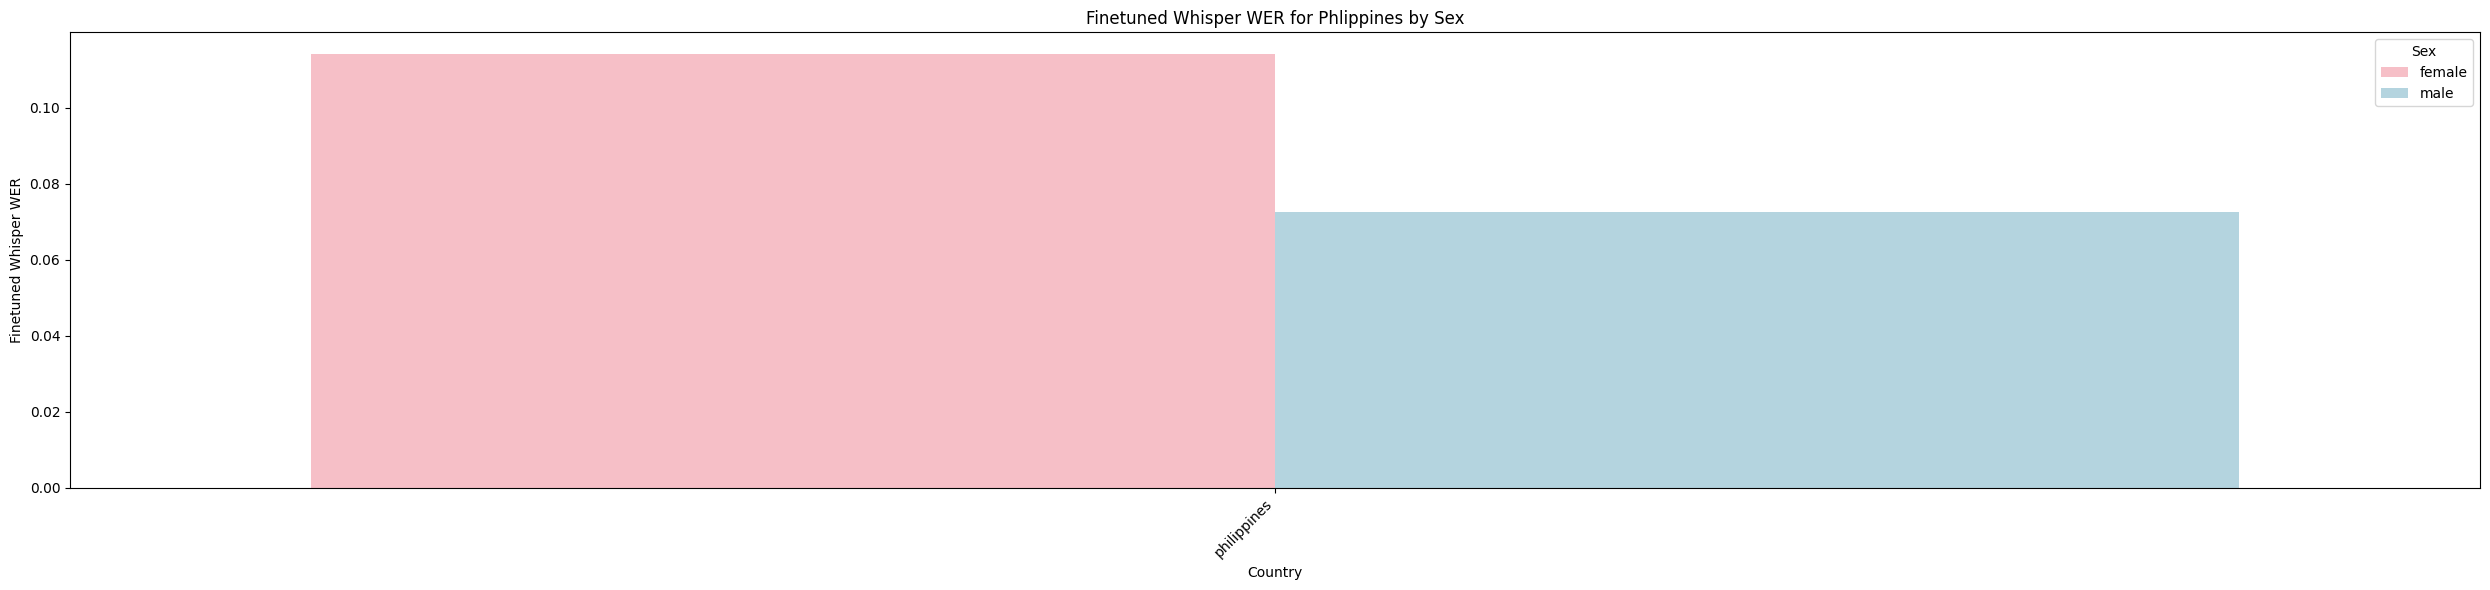

In [ ]:
#Plotting by sex

# Grouped bar plot
f = plt.figure(figsize=(25, 6))
ax = f.add_subplot(1, 1, 1)
color_palette = {"male": "lightblue", "female": "lightpink"}

# Plot
sns.barplot(data=new_filipino_df, x="country", y="WER_Finetuned", hue="sex", ax=ax,
            palette=color_palette, ci=None)

# Customizing the plot
ax.set_title("Finetuned Whisper WER for Phlippines by Sex")
ax.set_xlabel("Country")
ax.set_ylabel("Finetuned Whisper WER")
ax.legend(title="Sex", loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

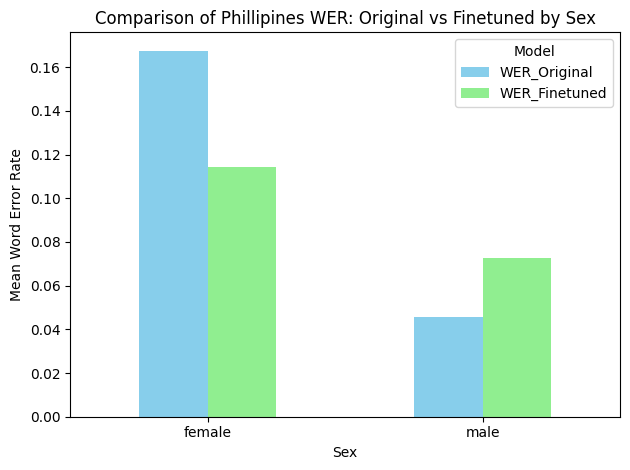

In [ ]:
# Calculating mean WER by sex
mean_wer = new_filipino_df.groupby('sex')[['WER_Original', 'WER_Finetuned']].mean()

# Plotting
mean_wer.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Comparison of Phillipines WER: Original vs Finetuned by Sex')
plt.xlabel('Sex')
plt.ylabel('Mean Word Error Rate')
plt.xticks(rotation=0)  # Rotates labels to be horizontal
plt.legend(title='Model')
plt.tight_layout()

# Show plot
plt.show()